### Generate some statistics files

In [1]:
! pip install libsumo addict

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import analysis.stats_utils as stats_utils
from analysis.viz_utils import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/"
mode="ITE_autoware_universe_map_recalibrate_v7"
user = "haowei"
experiment_record_repo = f"{exp_repo}/{mode}/raw_data"
export_stat_dir = f"{exp_repo}/{mode}/{user}/processed_data"

# # test code
# experiment_record_repo = "output/test/raw_data"
# export_stat_dir = "output/test/processed_data"
# export_stat_dir = "."

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [3]:
stats_utils.export_to_csv(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 20650/20650 [01:25<00:00, 240.62it/s]


info_error:  0


0

In [4]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#### Import statistics of each experiment

In [6]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v7_361_1,1305.0,1005,300,NaN,NaN,-0.053210,627,NaN,-1.0,NaN,NaN,55007.596928,5960.821132,NaN,NaN,NaN,None,-10.00,NaN
1,ITE_autoware_universe_map_recalibrate_v7_361_2,1355.0,1055,300,NaN,NaN,-0.061411,546,NaN,-1.0,NaN,NaN,64478.767646,3338.288505,NaN,NaN,NaN,None,-10.00,NaN
2,ITE_autoware_universe_map_recalibrate_v7_361_3,1161.3,956,300,BV_17.49,BV_17.50,3.211364,673,BV_17.49,1.0,RightFoll,roundabout_cutin,41752.073517,5230.343653,:NODE_6_0_0,angle,roundabout,30.223376521326884,3.28,4.214739
3,ITE_autoware_universe_map_recalibrate_v7_361_4,1318.0,1018,300,NaN,NaN,6.517985,1273,NaN,-1.0,NaN,NaN,70027.911686,4388.385365,NaN,NaN,NaN,None,-10.00,NaN
4,ITE_autoware_universe_map_recalibrate_v7_361_5,1335.0,1035,300,NaN,NaN,-0.133135,1589,NaN,-1.0,NaN,NaN,51449.914554,3475.368574,NaN,NaN,NaN,None,-10.00,NaN


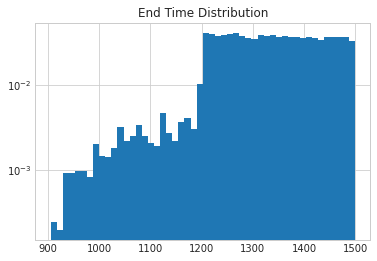

In [7]:
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [8]:
warm_up_time = exp_stats_info["warmup_time"]
estimated_end_time = exp_stats_info["warmup_time"] + exp_stats_info["run_time"]

has_collision = (exp_stats_info['end_time'] < estimated_end_time) & (exp_stats_info['end_time'] >= warm_up_time)
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 2169 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [9]:
collision_df.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
2,ITE_autoware_universe_map_recalibrate_v7_361_3,1161.3,956,300,BV_17.49,BV_17.50,3.211364,673,BV_17.49,1.0,RightFoll,roundabout_cutin,41752.073517,5230.343653,:NODE_6_0_0,angle,roundabout,30.223376521326884,3.280000,4.214739
9,ITE_autoware_universe_map_recalibrate_v7_361_10,1312.3,1118,300,BV_1.12,BV_1.13,3.210362,940,BV_1.13,2.2,Lead,intersection_rearend,38221.024369,1190.565898,EG_13_1_1_0,rear_end,intersection,3.126388037344441e-13,-0.549215,6.395792
31,ITE_autoware_universe_map_recalibrate_v7_361_32,1147.1,1025,300,BV_8.59,BV_22.15,3.234172,480,BV_22.15,2.0,Lead,intersection_rearend,24993.201813,2013.969648,EG_4_1_1_0,rear_end,intersection,9.21617066341787,0.064316,6.257397
48,ITE_autoware_universe_map_recalibrate_v7_306_9,1212.8,915,300,BV_14.14,BV_14.15,6.039257,1011,BV_14.15,2.4,Lead,intersection_rearend,62297.793229,4156.536037,EG_13_1_1_0,rear_end,intersection,0.0,-0.381685,5.983254
53,ITE_autoware_universe_map_recalibrate_v7_306_14,1116.9,970,300,BV_21.60,BV_17.56,3.237413,536,BV_21.60,0.6,RightFoll,highway_cutin,29449.290164,3443.023021,EG_1_3_1_0,sideswipe,freeway_1,18.53249497188247,-0.954573,2.191113


In [10]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - exp_stats_info["warmup_time"]).sum()
all_routes = exp_stats_info["route_length"].sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[(power_importance_weight < 1) & has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 20650
Number of collision: 2169
Collisions with weight less than 1: 2020
Importance summation: 2.122978075007306
Max weight: 0.015295564575501106, Min weight: 1.4624909191344517e-10
raw collision rate: 0.1050363196125908
adjusted collision rate (importance): 0.00010280765496403419
Collision due to traffic light ignorance: 111
Overall maneuvers: 18295579
Collision without negligence: 159
Maximum time between collision and negligence: 4.60 s

Overall time: 5861218.30 s
Maneuvers per second: 3.1214635018798056
Overall route length: 1164095580.23 m
m/s: 198.60983171923783
Overall route length: 723335.4585674145 mile
mile/s: 0.12341042792543908 mile/s
Crash per mile: 2.934984107113899e-06 crash/mile


In [11]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v7_361_1,1305.0,1005,300,NaN,NaN,-0.053210,627,NaN,-1.0,NaN,NaN,55007.596928,5960.821132,NaN,NaN,NaN,None,-10.00,NaN
1,ITE_autoware_universe_map_recalibrate_v7_361_2,1355.0,1055,300,NaN,NaN,-0.061411,546,NaN,-1.0,NaN,NaN,64478.767646,3338.288505,NaN,NaN,NaN,None,-10.00,NaN
2,ITE_autoware_universe_map_recalibrate_v7_361_3,1161.3,956,300,BV_17.49,BV_17.50,3.211364,673,BV_17.49,1.0,RightFoll,roundabout_cutin,41752.073517,5230.343653,:NODE_6_0_0,angle,roundabout,30.223376521326884,3.28,4.214739
3,ITE_autoware_universe_map_recalibrate_v7_361_4,1318.0,1018,300,NaN,NaN,6.517985,1273,NaN,-1.0,NaN,NaN,70027.911686,4388.385365,NaN,NaN,NaN,None,-10.00,NaN
4,ITE_autoware_universe_map_recalibrate_v7_361_5,1335.0,1035,300,NaN,NaN,-0.133135,1589,NaN,-1.0,NaN,NaN,51449.914554,3475.368574,NaN,NaN,NaN,None,-10.00,NaN


In [12]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < exp_stats_info["warmup_time"] + exp_stats_info["run_time"])]
a

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
127,ITE_autoware_universe_map_recalibrate_v7_244_3,1252.3,1121,300,BV_16.19,BV_7.8,-0.083494,682,BV_7.8,-1.0,NaN,NaN,27679.265338,2189.882115,:NODE_18_10_0,angle,intersection,119.29203891360442,3.280000,5.887706
322,ITE_autoware_universe_map_recalibrate_v7_454_25,999.0,925,300,BV_14.6,BV_21.51,-0.014715,54,BV_21.51,-1.0,NaN,NaN,14397.498320,1593.618450,:nd_34_1_6_0_0,rear_end,roundabout_1,27.48782116591417,-1.000000,3.614094
453,ITE_autoware_universe_map_recalibrate_v7_224_31,1211.3,1170,300,BV_8.50,BV_21.50,-0.018400,242,BV_21.50,-1.0,NaN,NaN,7559.985080,560.925612,:nd_34_1_6_0_0,angle,roundabout_1,24.424511325694084,3.280000,2.409578
826,ITE_autoware_universe_map_recalibrate_v7_282_32,1393.7,1116,300,BV_17.58,BV_14.15,-0.095967,761,BV_14.15,-1.0,NaN,NaN,53227.339883,3309.389019,:nd_34_1_6_1_0,sideswipe,roundabout_1,13.505793109416118,3.280000,2.243772
863,ITE_autoware_universe_map_recalibrate_v7_489_29,1107.1,1008,300,BV_9.20,BV_9.21,-0.086856,247,BV_9.21,-1.0,NaN,NaN,18841.419941,658.865623,EG_16_45_1_1,angle,roundabout_2,65.57694039317722,-1.821605,2.194423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19909,ITE_autoware_universe_map_recalibrate_v7_252_34,1203.4,1021,300,BV_8.71,BV_17.59,-0.095587,624,BV_17.59,-1.0,NaN,NaN,37292.675343,2065.365590,:nd_34_1_6_0_0,rear_end,roundabout_1,31.609402879193908,-1.000000,3.179192
20243,ITE_autoware_universe_map_recalibrate_v7_1_37,1336.9,1127,300,BV_16.17,BV_13.17,-0.142044,1016,BV_13.17,-1.0,NaN,NaN,48034.071224,1717.520873,:NODE_18_10_0,angle,intersection,120.83665460811073,3.280000,4.742402
20273,ITE_autoware_universe_map_recalibrate_v7_162_25,1160.7,984,300,BV_16.26,BV_3.11,-0.114286,1221,BV_3.11,-1.0,NaN,NaN,40859.296583,1656.486078,:NODE_18_17_0,head_on,intersection,148.25122986670954,3.280000,8.836076
20376,ITE_autoware_universe_map_recalibrate_v7_432_15,1164.8,935,300,BV_16.21,BV_13.7,-0.111287,997,BV_13.7,-1.0,NaN,NaN,51700.239845,1953.507359,:NODE_18_10_0,head_on,intersection,121.05510388012641,3.280000,5.539947


#### BV_22 Collision

In [13]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_collision_df = collision_df[has_bv_22]

total_bv_22_distance = exp_stats_info["bv_22_route_length"].sum()

num_bv_22_expr = np.sum(has_bv_22)
bv_22_collision_is_large_1 = bv_22_collision_df["importance"] < 0
power_bv_22_weight = np.power(10, -bv_22_collision_df["importance"])[~bv_22_collision_is_large_1]
bv_22_importance = np.sum(power_bv_22_weight)

print("Number of bv_22 collision:", num_bv_22_expr)
print("Total bv_22 distance:", total_bv_22_distance)
print("Number of bv_22 collision importance > 1:", np.sum(bv_22_collision_is_large_1))
print("Raw collision rate:", num_bv_22_expr / num_experiments)
print("Collision rate:", bv_22_importance / num_experiments)
print("Collision rate (weighted):", bv_22_importance / total_bv_22_distance * mile_to_m)

Number of bv_22 collision: 200
Total bv_22 distance: 59917760.5934391
Number of bv_22 collision importance > 1: 11
Raw collision rate: 0.009685230024213076
Collision rate: 1.1215809308435225e-05
Collision rate (weighted): 6.220767709641167e-06


### Crash Distribution (with negligence)

In [14]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200) & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [15]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v7_361_1,1305.0,1005,300,NaN,NaN,-0.053210,627,NaN,-1.0,NaN,NaN,55007.596928,5960.821132,NaN,NaN,NaN,None,-10.00,NaN
1,ITE_autoware_universe_map_recalibrate_v7_361_2,1355.0,1055,300,NaN,NaN,-0.061411,546,NaN,-1.0,NaN,NaN,64478.767646,3338.288505,NaN,NaN,NaN,None,-10.00,NaN
2,ITE_autoware_universe_map_recalibrate_v7_361_3,1161.3,956,300,BV_17.49,BV_17.50,3.211364,673,BV_17.49,1.0,RightFoll,roundabout_cutin,41752.073517,5230.343653,:NODE_6_0_0,angle,roundabout,30.223376521326884,3.28,4.214739
3,ITE_autoware_universe_map_recalibrate_v7_361_4,1318.0,1018,300,NaN,NaN,6.517985,1273,NaN,-1.0,NaN,NaN,70027.911686,4388.385365,NaN,NaN,NaN,None,-10.00,NaN
4,ITE_autoware_universe_map_recalibrate_v7_361_5,1335.0,1035,300,NaN,NaN,-0.133135,1589,NaN,-1.0,NaN,NaN,51449.914554,3475.368574,NaN,NaN,NaN,None,-10.00,NaN


In [16]:
# collision: negligence-caused 和 no negligence caused (SUMO)
# 每个种类做collision node的分布
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))

2011 159


Negligence caused distribution

In [17]:
neg_caused_collision["lane_id"].value_counts()

EG_25_2_1_0     201
EG_1_3_1_1      171
EG_16_23_1_1    153
EG_1_3_1_0      138
EG_13_1_1_0      84
               ... 
:NODE_11_8_0      1
:NODE_19_1_0      1
EG_23_2_1_0       1
:NODE_21_1_0      1
EG_21_1_14_0      1
Name: lane_id, Length: 110, dtype: int64

No negligence caused distribution

In [18]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

:NODE_18_10_0     95
:nd_34_1_6_0_0    26
:nd_34_1_6_1_0    14
:NODE_11_15_0      7
EG_16_45_1_1       6
EG_18_12_171_1     3
:NODE_18_8_0       3
:NODE_11_16_0      2
:NODE_18_17_0      2
:NODE_24_5_0       1
Name: lane_id, dtype: int64
159


### Crash Distribution (with negligence)

In [19]:
neg_caused_collision.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
2,ITE_autoware_universe_map_recalibrate_v7_361_3,1161.3,956,300,BV_17.49,BV_17.50,3.211364,673,BV_17.49,1.0,RightFoll,roundabout_cutin,41752.073517,5230.343653,:NODE_6_0_0,angle,roundabout,30.223376521326884,3.280000,4.214739
9,ITE_autoware_universe_map_recalibrate_v7_361_10,1312.3,1118,300,BV_1.12,BV_1.13,3.210362,940,BV_1.13,2.2,Lead,intersection_rearend,38221.024369,1190.565898,EG_13_1_1_0,rear_end,intersection,3.126388037344441e-13,-0.549215,6.395792
31,ITE_autoware_universe_map_recalibrate_v7_361_32,1147.1,1025,300,BV_8.59,BV_22.15,3.234172,480,BV_22.15,2.0,Lead,intersection_rearend,24993.201813,2013.969648,EG_4_1_1_0,rear_end,intersection,9.21617066341787,0.064316,6.257397
48,ITE_autoware_universe_map_recalibrate_v7_306_9,1212.8,915,300,BV_14.14,BV_14.15,6.039257,1011,BV_14.15,2.4,Lead,intersection_rearend,62297.793229,4156.536037,EG_13_1_1_0,rear_end,intersection,0.0,-0.381685,5.983254
53,ITE_autoware_universe_map_recalibrate_v7_306_14,1116.9,970,300,BV_21.60,BV_17.56,3.237413,536,BV_21.60,0.6,RightFoll,highway_cutin,29449.290164,3443.023021,EG_1_3_1_0,sideswipe,freeway_1,18.53249497188247,-0.954573,2.191113


In [20]:
def crash_distribution(neg_caused_collision, feat_name):
    crash_type_dist = neg_caused_collision.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [21]:
neg_caused_collision = neg_caused_collision.copy()
neg_caused_collision["exp_importance"] = np.power(10, -neg_caused_collision["importance"])

# ! should be commmented later
neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
neg_caused_collision["location"] = list(map(get_type_func, neg_caused_collision["location_type"]))
neg_caused_collision["collision"] = list(map(get_type_func, neg_caused_collision["collision_type"]))


crash_type_dist = crash_distribution(neg_caused_collision, "collision")
crash_type_dist

/tmp/ipykernel_732203/1315232982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,28,0.015702,0.001356,7.603761e-07
1,freeway,rear,37,0.311839,0.001792,1.510117e-05
2,freeway,sideswipe,310,0.166175,0.015012,8.047203e-06
3,intersection,angle,246,0.622036,0.011913,3.012282e-05
4,intersection,head,102,0.079104,0.004939,3.830704e-06
5,intersection,rear,907,0.512674,0.043923,2.482684e-05
6,intersection,sideswipe,197,0.304474,0.009540,1.474451e-05
7,roundabout,angle,113,0.059802,0.005472,2.895997e-06
8,roundabout,rear,24,0.013076,0.001162,6.332118e-07
9,roundabout,sideswipe,47,0.026231,0.002276,1.270287e-06


location
freeway         0.232558
intersection    0.715169
roundabout      0.046684
Name: exp_importance, dtype: float64


Text(0.5, 1.0, 'ground truth')

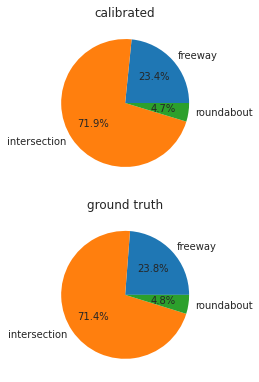

In [22]:
location_distribution = neg_caused_collision.groupby("location").sum()/importance_all
proportion = location_distribution["exp_importance"]
print(proportion)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=proportion)
plt.title("calibrated")
plt.subplot(3, 1, 2)
true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=true_dist)
plt.title("ground truth")

In [23]:
def pie_chart_plot(df, mode, feat_name):
    mark = df["location"] == mode
    labels = df[mark][feat_name]
    values = df[mark]["importance_rate"]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{mode}')
    # plt.legend(labels)

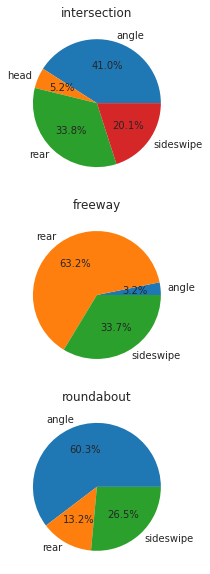

In [24]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

In [25]:
len(neg_caused_collision)

2011

#### Negligence reason

In [26]:
neg_reason_crash_dist = crash_distribution(neg_caused_collision, "neg_reason")
neg_reason_crash_dist

,location,neg_reason,count,exp_importance,collision_rate,importance_rate
0,freeway,Lead,35,0.310081,0.001695,1.501602e-05
1,freeway,LeftFoll,188,0.102413,0.009104,4.959450e-06
2,freeway,RightFoll,152,0.081222,0.007361,3.933284e-06
3,intersection,Lead,1039,0.546079,0.050315,2.644451e-05
4,intersection,LeftFoll,224,0.346282,0.010847,1.676912e-05
5,intersection,RightFoll,78,0.108300,0.003777,5.244534e-06
6,intersection,TFL,111,0.517627,0.005375,2.506670e-05
7,roundabout,Lead,32,0.017165,0.001550,8.312234e-07
8,roundabout,LeftFoll,61,0.032381,0.002954,1.568106e-06
9,roundabout,RightFoll,91,0.049563,0.004407,2.400166e-06


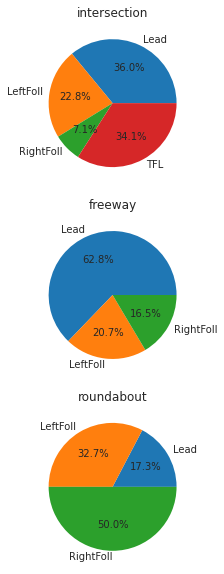

In [27]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(neg_reason_crash_dist, "intersection", "neg_reason")
plt.subplot(3, 1, 2)
pie_chart_plot(neg_reason_crash_dist, "freeway", "neg_reason")
plt.subplot(3, 1, 3)
pie_chart_plot(neg_reason_crash_dist, "roundabout", "neg_reason")
plt.savefig(f"{export_stat_dir}/neg_reason_pie_chart.png")

#### BV 22 Negligence Caused

In [28]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_neg_caused_collision = neg_caused_collision[has_bv_22]



bv_22_crash_type_dist = crash_distribution(bv_22_neg_caused_collision, "collision")
bv_22_crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,2,0.001140,0.000097,5.521246e-08
1,freeway,rear,5,0.033783,0.000242,1.635972e-06
2,freeway,sideswipe,33,0.017481,0.001598,8.465215e-07
3,intersection,angle,26,0.047976,0.001259,2.323314e-06
4,intersection,rear,48,0.028249,0.002324,1.368009e-06
5,intersection,sideswipe,56,0.092740,0.002712,4.491054e-06
6,roundabout,angle,9,0.004787,0.000436,2.318292e-07
7,roundabout,rear,4,0.002065,0.000194,1.000242e-07
8,roundabout,sideswipe,4,0.002246,0.000194,1.087654e-07


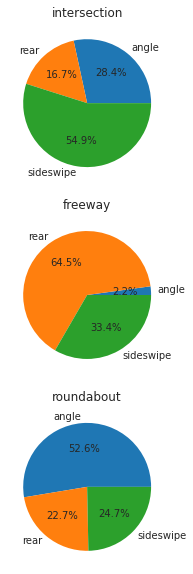

In [29]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

##### EG happened collision intersection&angle

In [30]:
eg_collision = list(neg_caused_collision["lane_id"])
eg_collision_angle_df = neg_caused_collision[((neg_caused_collision["collision"] == "angle") | (neg_caused_collision["collision"] == "sideswipe")) & (neg_caused_collision["location"] == "freeway")]
# print(neg_caused_collision["relative_heading"])
# print(len(neg_caused_collision["relative_heading"]))

heading_float_list = [float(heading) for heading in eg_collision_angle_df["relative_heading"] if heading != 'None']
heading_float_list = np.array(heading_float_list)
print(len(heading_float_list))

338


In [31]:
eg_collision_angle_df = eg_collision_angle_df.sort_values(by="relative_heading")
eg_collision_angle_df["exp_cum"] = eg_collision_angle_df["exp_importance"].cumsum() / eg_collision_angle_df["exp_importance"].sum()
eg_collision_angle_df[eg_collision_angle_df["exp_cum"] < 28.08/(28.08+2.52)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,...,lane_id,collision_type,location_type,relative_heading,distance,collision_severity,exp_importance,location,collision,exp_cum
6158,ITE_autoware_universe_map_recalibrate_v7_471_29,1270.5,1040,300,BV_17.56,BV_21.72,9.330778,807,BV_17.56,0.6,...,EG_1_1_1_1,sideswipe,freeway_2,16.529870866723485,-0.878791,3.138981,4.668976e-10,freeway,sideswipe,2.567113e-09
15447,ITE_autoware_universe_map_recalibrate_v7_369_12,1040.2,1006,300,BV_21.53,BV_17.55,3.290358,172,BV_21.53,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,16.613323425948153,-0.185129,4.027292,5.124382e-04,freeway,sideswipe,2.817509e-03
1439,ITE_autoware_universe_map_recalibrate_v7_258_16,1126.1,1052,300,BV_17.52,BV_8.63,3.285881,182,BV_17.52,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.666041428611678,-0.903146,3.337755,5.177482e-04,freeway,sideswipe,5.664211e-03
12666,ITE_autoware_universe_map_recalibrate_v7_212_4,1159.8,910,300,BV_21.54,BV_8.67,3.209898,809,BV_21.54,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.735676386913923,-0.503913,3.990085,6.167403e-04,freeway,sideswipe,9.055195e-03
13431,ITE_autoware_universe_map_recalibrate_v7_307_33,1122.9,999,300,BV_21.72,BV_17.54,3.232119,435,BV_21.72,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.841826148711007,-2.601584,2.103518,5.859777e-04,freeway,sideswipe,1.227704e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19328,ITE_autoware_universe_map_recalibrate_v7_29_24,1273.6,1191,300,BV_8.83,BV_21.65,3.268048,332,BV_8.83,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.90894018258939,-0.978876,1.934784,5.394506e-04,freeway,sideswipe,9.038511e-01
12270,ITE_autoware_universe_map_recalibrate_v7_196_39,1194.0,1155,300,BV_21.51,BV_17.55,3.293562,122,BV_21.51,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,19.92299425266856,-1.524409,2.345671,5.086726e-04,freeway,sideswipe,9.066479e-01
6371,ITE_autoware_universe_map_recalibrate_v7_296_15,1303.7,1042,300,BV_8.74,BV_21.58,3.174259,1285,BV_8.74,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.988372017412416,-2.467508,2.180913,6.694854e-04,freeway,sideswipe,9.103289e-01
2196,ITE_autoware_universe_map_recalibrate_v7_130_20,1196.3,997,300,BV_17.62,BV_17.65,3.216593,968,BV_17.62,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,19.990501633369036,-0.880257,1.792787,6.073057e-04,freeway,sideswipe,9.136680e-01


0.08284023668639054


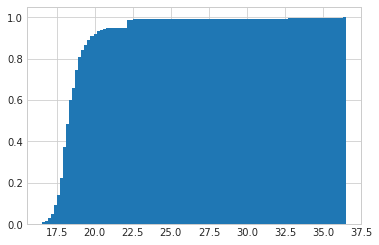

In [32]:
# # draw the histogram of the relative_heading of the collision in each location in neg_caused_collision
# grouped_neg_collision = neg_caused_collision["relative_heading"].groupby(neg_caused_collision["location"])
# for name, group_data in grouped_neg_collision:
#     plt.figure()
#     plt.hist(group_data, bins=50)
#     # plt.title(f"Collision Relative Heading Distribution in {name}")
# heading_flaot_list = np.clip(heading_flaot_list, 0, 30)
plt.figure()
plt.hist(heading_float_list, bins=100, density=True, cumulative=True)

print(np.sum(heading_float_list>20)/len(heading_float_list))

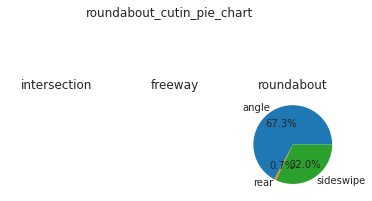

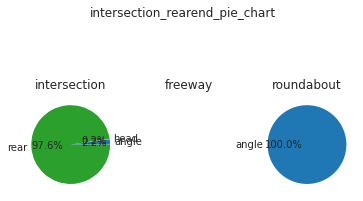

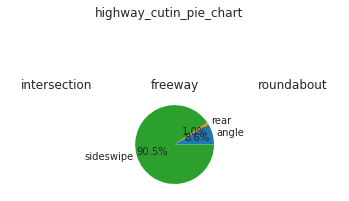

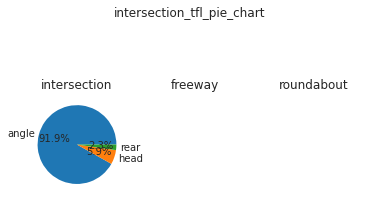

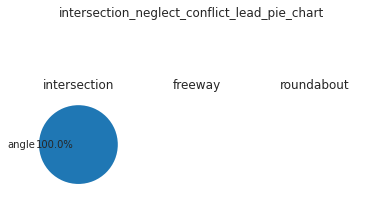

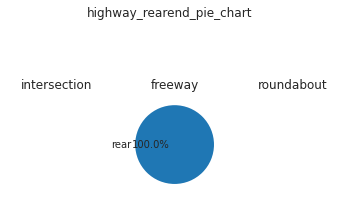

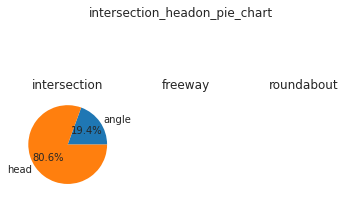

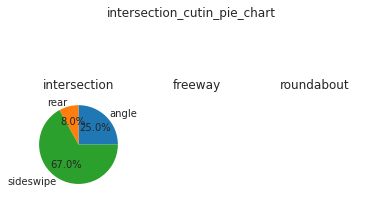

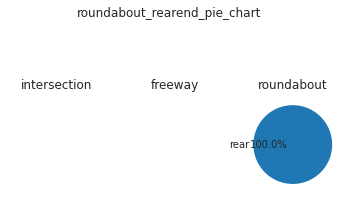

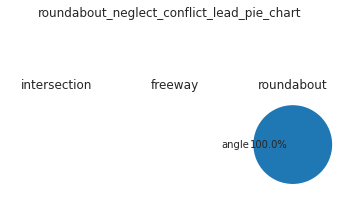

In [33]:
neg_uniq_infos = neg_caused_collision["neg_info"].unique()

neg_info_crash_dist = {}
for info in neg_uniq_infos:
    df = neg_caused_collision[neg_caused_collision["neg_info"] == info].copy()
    
    crash_type_dist = crash_distribution(df, "collision")
    neg_info_crash_dist[info] = crash_type_dist
    plt.figure()
    plt.subplot(1, 3, 1)
    pie_chart_plot(crash_type_dist, "intersection", "collision")
    plt.subplot(1, 3, 2)
    pie_chart_plot(crash_type_dist, "freeway", "collision")
    plt.subplot(1, 3, 3)
    pie_chart_plot(crash_type_dist, "roundabout", "collision")
    plt.suptitle(f"{info}_pie_chart")
    plt.savefig(f"{export_stat_dir}/{info}_pie_chart.png")

In [34]:
from IPython.display import display
for info, crash_dist in neg_info_crash_dist.items():
    print(info)
    display(crash_dist)

roundabout_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,104,0.055117,0.005036,2.669097e-06
1,roundabout,rear,1,0.000597,0.000048,2.888891e-08
2,roundabout,sideswipe,47,0.026231,0.002276,1.270287e-06


intersection_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,19,0.010308,0.000920,4.991567e-07
1,intersection,head,3,0.001067,0.000145,5.165382e-08
2,intersection,rear,879,0.464777,0.042567,2.250734e-05
3,roundabout,angle,1,0.000631,0.000048,3.053906e-08


highway_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,28,0.015702,0.001356,7.603761e-07
1,freeway,rear,2,0.001758,0.000097,8.515504e-08
2,freeway,sideswipe,310,0.166175,0.015012,8.047203e-06


intersection_tfl


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,91,0.469953,0.004407,2.275803e-05
1,intersection,head,6,0.030136,0.000291,1.459370e-06
2,intersection,rear,2,0.011535,0.000097,5.585880e-07


intersection_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,35,0.016472,0.001695,7.976697e-07


highway_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,35,0.310081,0.001695,0.000015


intersection_headon


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,22,0.011558,0.001065,5.597195e-07
1,intersection,head,93,0.047901,0.004504,2.319681e-06


intersection_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,79,0.113745,0.003826,0.000006
1,intersection,rear,26,0.036363,0.001259,0.000002
2,intersection,sideswipe,197,0.304474,0.009540,0.000015


roundabout_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,rear,23,0.012479,0.001114,6.043229e-07


roundabout_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,8,0.004055,0.000387,1.963614e-07


In [35]:
! pip install gurobipy
col_names = ["ia", "ih", "ir", "is", "ra", "rr", "rs", "fr", "fs", "fa"]

row_names = [
    "intersection_cutin", 
    "intersection_neglect_conflict_lead", 
    "intersection_rearend", 
    "intersection_tfl",
    "intersection_headon",
    "roundabout_cutin",
    "roundabout_neglect_conflict_lead",
    "roundabout_rearend",
    "highway_cutin",
    "highway_rearend"
]

translate_col = {col: i for i, col in enumerate(col_names)}
translate_row = {row: i for i, row in enumerate(row_names)}

A = np.zeros((len(translate_row), len(translate_col))).astype(int)
for row_mark in neg_info_crash_dist.keys():
    df = neg_info_crash_dist[row_mark]
    important_values = df["importance_rate"]
    col_marks = np.array(list(map(lambda x: x[1][0][0]+x[1][1][0], df.iterrows())))
    for col_mark, v in zip(col_marks, important_values):
        if col_mark in translate_col:
            A[translate_row[row_mark], translate_col[col_mark]] = v * 1e9
A = A.T

Defaulting to user installation because normal site-packages is not writeable


In [36]:
A[:4, 5:] = 0
A[4:, :5] = 0
A[:7, 8:] = 0
A[7:, :8] = 0

In [37]:
A

array([[ 5508,   797,   499, 22758,   559,     0,     0,     0,     0,
            0],
       [    0,     0,    51,  1459,  2319,     0,     0,     0,     0,
            0],
       [ 1760,     0, 22507,   558,     0,     0,     0,     0,     0,
            0],
       [14744,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,  2669,   196,     0,     0,
            0],
       [    0,     0,     0,     0,     0,    28,     0,   604,     0,
            0],
       [    0,     0,     0,     0,     0,  1270,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,    85,
        15016],
       [    0,     0,     0,     0,     0,     0,     0,     0,  8047,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   760,
            0]])

#### Calibration

In [38]:
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# basic parameters
n = A.shape[1]
m = A.shape[0]
b = np.array([1839, 285, 1648, 808, 169, 53, 85, 1058, 428, 38])
all_miles = all_routes / mile_to_m
b = b / b.sum() * all_miles / num_experiments * 3e3

# Gurobi model
model = gp.Model()
model.reset()

# variable
x = model.addVars(range(n), lb=0.1)
t = model.addVars(range(m), lb=0)
upper = model.addVar(lb=1)
lower = model.addVar(lb=0)

# optimization goal
model.setObjective(sum(t[i] for i in range(m)) + 20 * upper + 200 * (1-lower), GRB.MINIMIZE)

# constraints
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] <= t[i] for i in range(m))
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] >= -t[i] for i in range(m))
model.addConstrs(x[i] <= upper for i in range(n))
model.addConstrs(x[i] >= lower for i in range(n))
model.update()

# solve the model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Solution:")
# x_solved = np.array([x[i].X for i in range(n)]).reshape(-1, 1)
# t_solved = np.array([t[i].X for i in range(m)]).reshape(-1, 1)
x_solved = [x[i].X for i in range(n)]
t_solved = [t[i].X for i in range(m)]
x_mark_solved = list(zip(translate_row, x_solved))
t_mark_solved = list(zip(translate_col, t_solved))
print("x =",  *x_mark_solved, sep="\n")
print("t =",  *t_mark_solved, sep="\n")
print("x upper bound = ", upper.X)
print("x upper bound = ", lower.X)
print("b =", b)

Restricted license - for non-production use only - expires 2024-10-28
Discarded solution information
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads

Optimize a model with 40 rows, 22 columns and 102 nonzeros
Model fingerprint: 0x79041723
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [6e+02, 3e+04]
Presolve time: 0.25s
Presolved: 40 rows, 22 columns, 102 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0000000e+32   1.000000e+31   2.000000e+02      0s
      16    2.4965695e+02   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.33 seconds (0.00 work units)
Optimal objective  2.496569456e+02
 
***** Solution:
x =
('intersection_cutin', 0.8982789352449969)

### Quick check

In [39]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                                                 
               nunique                                            first
lane_id                                                                
:NODE_18_10_0       95   ITE_autoware_universe_map_recalibrate_v7_244_3
:nd_34_1_6_0_0      26  ITE_autoware_universe_map_recalibrate_v7_454_25
:nd_34_1_6_1_0      14  ITE_autoware_universe_map_recalibrate_v7_282_32
:NODE_11_15_0        7   ITE_autoware_universe_map_recalibrate_v7_246_4
EG_16_45_1_1         6  ITE_autoware_universe_map_recalibrate_v7_489_29
:NODE_18_8_0         3   ITE_autoware_universe_map_recalibrate_v7_121_1
EG_18_12_171_1       3  ITE_autoware_universe_map_recalibrate_v7_256_11
:NODE_11_16_0        2  ITE_autoware_universe_map_recalibrate_v7_113_28
:NODE_18_17_0        2   ITE_autoware_universe_map_recalibrate_v7_92_14
:NODE_24_5_0         1  ITE_autoware_universe_map_recalibrate_v7_469_16

0.015295564575501106 1.4624909191344517e-10


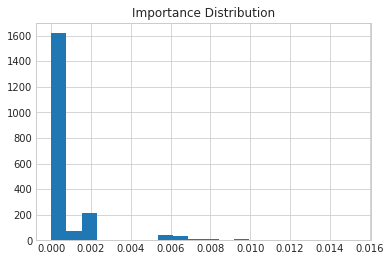

In [40]:
plt.hist(collide_importance_weight, bins=20)
plt.title("Importance Distribution")
plt.savefig(f'{export_stat_dir}/importance.png', dpi=300)
print(collide_importance_weight.max(), collide_importance_weight.min())

#### Export the checklist

In [41]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

In [42]:
# ! pip install shapely

In [43]:
exp_stats_info

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v7_361_1,1305.0,1005,300,NaN,NaN,-0.053210,627,NaN,-1.0,NaN,NaN,55007.596928,5960.821132,NaN,NaN,NaN,None,-10.00,NaN
1,ITE_autoware_universe_map_recalibrate_v7_361_2,1355.0,1055,300,NaN,NaN,-0.061411,546,NaN,-1.0,NaN,NaN,64478.767646,3338.288505,NaN,NaN,NaN,None,-10.00,NaN
2,ITE_autoware_universe_map_recalibrate_v7_361_3,1161.3,956,300,BV_17.49,BV_17.50,3.211364,673,BV_17.49,1.0,RightFoll,roundabout_cutin,41752.073517,5230.343653,:NODE_6_0_0,angle,roundabout,30.223376521326884,3.28,4.214739
3,ITE_autoware_universe_map_recalibrate_v7_361_4,1318.0,1018,300,NaN,NaN,6.517985,1273,NaN,-1.0,NaN,NaN,70027.911686,4388.385365,NaN,NaN,NaN,None,-10.00,NaN
4,ITE_autoware_universe_map_recalibrate_v7_361_5,1335.0,1035,300,NaN,NaN,-0.133135,1589,NaN,-1.0,NaN,NaN,51449.914554,3475.368574,NaN,NaN,NaN,None,-10.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20645,ITE_autoware_universe_map_recalibrate_v7_188_39,1467.0,1167,300,NaN,NaN,-0.069112,621,NaN,-1.0,NaN,NaN,51668.977906,2022.951324,NaN,NaN,NaN,None,-10.00,NaN
20646,ITE_autoware_universe_map_recalibrate_v7_188_40,1213.0,913,300,NaN,NaN,-0.116750,1015,NaN,-1.0,NaN,NaN,59685.893001,3932.797898,NaN,NaN,NaN,None,-10.00,NaN
20647,ITE_autoware_universe_map_recalibrate_v7_188_41,1377.0,1077,300,NaN,NaN,-0.055574,522,NaN,-1.0,NaN,NaN,51386.079133,2260.185892,NaN,NaN,NaN,None,-10.00,NaN
20648,ITE_autoware_universe_map_recalibrate_v7_188_42,1292.0,992,300,NaN,NaN,-0.079944,945,NaN,-1.0,NaN,NaN,57521.964763,2798.575847,NaN,NaN,NaN,None,-10.00,NaN


### Generate videos in the check list

In [44]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [45]:
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            exp_id = line.strip()
            path_name = os.path.join(experiment_record_repo, exp_id)
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

In [46]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{mode}/{user}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

# quick check
# export_videos(f"{export_path}/quick_check", "check.txt")

export_videos(f"{export_path}/non_neg_check", non_neg_check_list_path)
# export_videos(f"{export_path}/neg_caused_check", neg_caused_check_list_path)

  0%|          | 0/159 [00:02<?, ?it/s]

/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/ITE_autoware_universe_map_recalibrate_v7/raw_data/final_state/ITE_autoware_universe_map_recalibrate_v7_173_final_state.json


FileNotFoundError: [Errno 2] No such file or directory: './maps/Mcity/mcity.net.xml'

### See README-viz.md for visualization

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()